In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [2]:
# 설정: 대상 동물과 데이터 경로 설정
target_animal = 'dog'  # 'cat', 'dog' 중 선택

# 경로 설정
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'image_data', target_animal)

sys.path.append(main_path)

if not os.path.exists(data_path):
    raise ValueError(f'No such animal data path: {data_path}')

state_list = [dir_path for dir_path in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, dir_path))]
print(f"분류할 상태 목록: {state_list}")

분류할 상태 목록: ['relax', 'hostile', 'whining']


/Users/jaewone/Downloads/FurEmotion-AI/image_data/dog/hostile/hostile_151.png


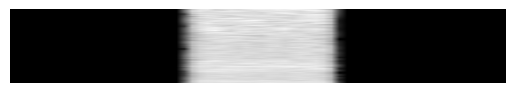

Image shape: (128, 862, 3)


In [57]:
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


random_file = np.random.choice([file for file in os.listdir(
    os.path.join(data_path, state_list[1])) if file.endswith('.png')])
test_file_path = os.path.join(data_path, state_list[1], str(random_file))
print(test_file_path)

display_image(test_file_path)

# print image shape
image = Image.open(test_file_path)
image_array = np.array(image)
print(f"Image shape: {image_array.shape}")

img_height, img_width, img_channel = image_array.shape

In [58]:
# 하이퍼파라미터 설정
batch_size = 32

# 데이터셋 로드 및 분할 (9:1 비율로 학습 및 테스트 데이터 분할)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"클래스 이름: {class_names}")

# 데이터 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 데이터 전처리 (ResNet50의 입력 형식에 맞게 조정)
from tensorflow.keras.applications.resnet50 import preprocess_input


def preprocess(image, label):
    image = preprocess_input(image)
    return image, label


train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

Found 469 files belonging to 3 classes.
Using 423 files for training.
Found 469 files belonging to 3 classes.
Using 46 files for validation.
클래스 이름: ['hostile', 'relax', 'whining']


In [59]:
# 모델 구성
num_classes = len(class_names)
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # 베이스 모델의 가중치 동결

# 커스텀 분류 레이어 추가
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# 전체 모델 구축
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [6]:
# 모델 훈련
epochs = 4
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/4
14/14 [==============================] - 37s 3s/step - loss: 1.0545 - accuracy: 0.5106 - val_loss: 0.8173 - val_accuracy: 0.5870
Epoch 2/4
14/14 [==============================] - 38s 3s/step - loss: 0.8869 - accuracy: 0.5910 - val_loss: 0.8712 - val_accuracy: 0.5652
Epoch 3/4
14/14 [==============================] - 39s 3s/step - loss: 0.9053 - accuracy: 0.5674 - val_loss: 0.8973 - val_accuracy: 0.5652
Epoch 4/4
14/14 [==============================] - 40s 3s/step - loss: 0.8650 - accuracy: 0.6099 - val_loss: 0.9197 - val_accuracy: 0.5435


In [9]:
# 모델 저장
model.save('resnet50_finetuned.h5')

/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


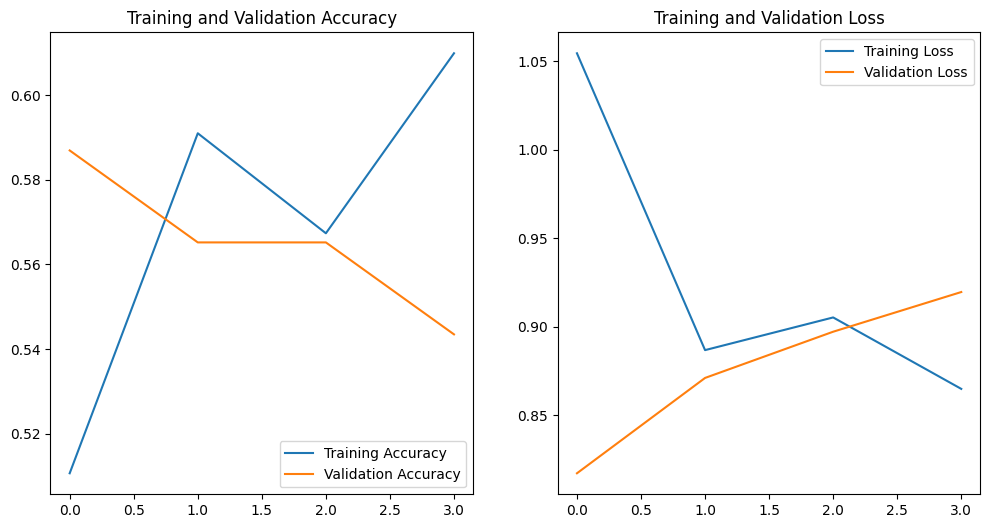

In [7]:
# 학습 결과 시각화 (정확도 및 손실 그래프)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 2s 2s/step


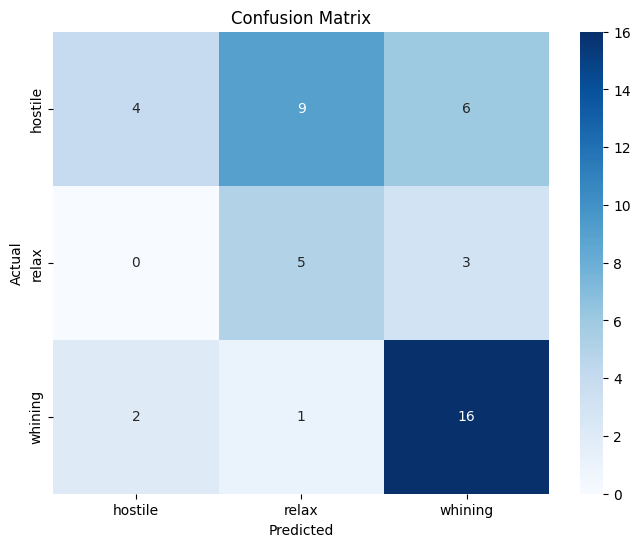

Classification Report
              precision    recall  f1-score   support

     hostile       0.67      0.21      0.32        19
       relax       0.33      0.62      0.43         8
     whining       0.64      0.84      0.73        19

    accuracy                           0.54        46
   macro avg       0.55      0.56      0.49        46
weighted avg       0.60      0.54      0.51        46



In [8]:
# 모델 평가 및 혼동 행렬 계산
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
            yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))